# Network Analysis on Auckland road data
### Import packages

In [1]:
import numpy as np
import pandas as pd
import osmnx as ox
import geopandas as gpd
from shapely.geometry import MultiPolygon, Point
from shapely.ops import transform
import pyproj
import networkx as nx
import math
import matplotlib.pyplot as plt
from pyproj import CRS
import itertools

### Generating or importing the road network

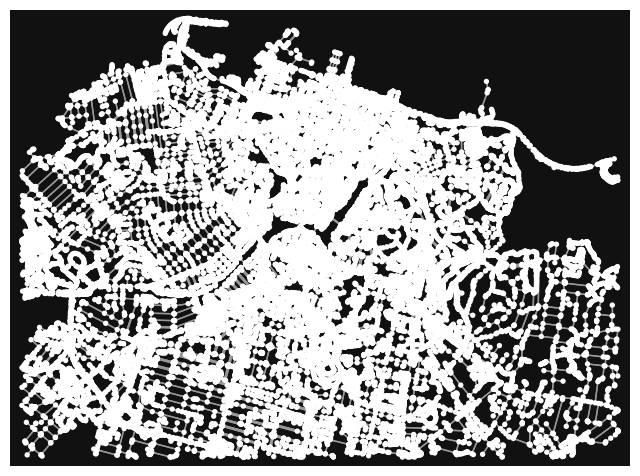

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [2]:
Gsmol = ox.graph.graph_from_address("Auckland, New Zealand", network_type="walk", simplify = False, dist =4000)
ox.plot_graph(Gsmol)

In [3]:
# Add speed and travel time
Gsmol = ox.add_edge_speeds(Gsmol)
Gsmol = ox.add_edge_travel_times(Gsmol)

In [4]:
#ox.io.save_graph_geopackage(Gsmol, "data/network_analysis/sample_network.gpkg")

### Nearest distances

# Adding other data

### Import the train stations in Auckland
The IDW was done in R. Code in the file data-prep.R

In [4]:
# Connect the supply points to the graph
#allstations = gpd.read_file("data/transport/public_transport/trains_auckland_with_distances_on_network.gpkg")

stations = gpd.read_file("data/transport/public_transport/sample_stations.gpkg")
stations['lon'] = stations['geometry'].x
stations['lat'] = stations['geometry'].y
stations["node"] = stations.geometry.apply(lambda x: ox.distance.nearest_nodes(Gsmol, x.x, x.y))
stations = gpd.GeoDataFrame(stations, geometry = stations.geometry)
stations

,OBJECTID,STOPID,STOPCODE,STOPNAME,STOPDESC,LOCATIONTYPE,STOPLAT,STOPLON,PARENTSTATION,MODE,lon,lat,u,v,dist,geometry,node
0,11,277,277,Grafton Train Station,None,Stop,-36.865612,174.769840,None,Train,174.769840,-36.865612,2765835305,2765835293,0,POINT (174.76984 -36.86561),3591613174
1,19,133,133,Britomart Train Station,None,Stop,-36.844291,174.768480,None,Train,174.768480,-36.844291,8808664536,8808664534,0,POINT (174.76848 -36.84429),8808664542
2,36,140,140,Parnell Train Station,None,Stop,-36.854728,174.777399,None,Train,174.777399,-36.854728,8628536361,3926522434,0,POINT (174.77740 -36.85473),8628536361
3,40,135,135,The Strand Train Station,None,Stop,-36.848536,174.779341,None,Train,174.779341,-36.848536,2981998375,7994688057,0,POINT (174.77934 -36.84854),7994688052


### Import the grid of urban Auckland including census variables
The IDW was done in R. Code in the file data-prep.R

In [5]:
# Connect the demand points to the graph
grid = gpd.read_file("data/geographic/grids/sample_grid_all.gpkg")
grid = gpd.GeoDataFrame(grid, geometry = grid.geometry)
grid = grid.to_crs(stations.crs)
grid['lon'] = grid['geometry'].x
grid['lat'] = grid['geometry'].y
grid["node"] = grid.geometry.apply(lambda x: ox.distance.nearest_nodes(Gsmol, x.x, x.y))                                                                         

grid.head(3)

,geometry,lon,lat,node
0,POINT (174.76739 -36.85513),174.767391,-36.855133,8605758309
1,POINT (174.76867 -36.85514),174.768671,-36.855141,1210037505
2,POINT (174.76995 -36.85515),174.769951,-36.855149,7210661923


In [7]:
# define function to acquire path
def get_path(G, origin, dest):
    path=ox.shortest_path(G, origin, dest, weight='travel_time') 
    return path

# define function to acquire path length
def get_path_len(G, path):
    path = sum(ox.utils_graph.get_route_edge_attributes(G, path, 'length'))
    return path

In [8]:
distances = []
for pidx, point in enumerate(grid.itertuples()):
    path_lengths = []

    for sidx, station in enumerate(stations.itertuples()):
        # get path
        path = get_path(Gsmol, grid['node'].iloc[pidx], stations['node'].iloc[sidx])
        path_len = get_path_len(Gsmol, path)
        path_lengths.append(path_len)
        
    min_dist_to_station = min(path_lengths)
    distances.append(min_dist_to_station)


In [9]:
grid['dist_station'] = distances

In [10]:
grid.head(5)

,geometry,lon,lat,node,dist_station
0,POINT (174.76739 -36.85513),174.767391,-36.855133,8605758309,1422.972
1,POINT (174.76867 -36.85514),174.768671,-36.855141,1210037505,1424.637
2,POINT (174.76995 -36.85515),174.769951,-36.855149,7210661923,1130.502
3,POINT (174.77123 -36.85516),174.771231,-36.855157,25770127,1055.096
4,POINT (174.77251 -36.85516),174.772511,-36.855165,7611758390,929.007


In [47]:
grid.to_file("data/grid_test_withdistancestostations.gpkg", driver="GPKG")

In [10]:
stations = stations.to_crs(grid.crs)

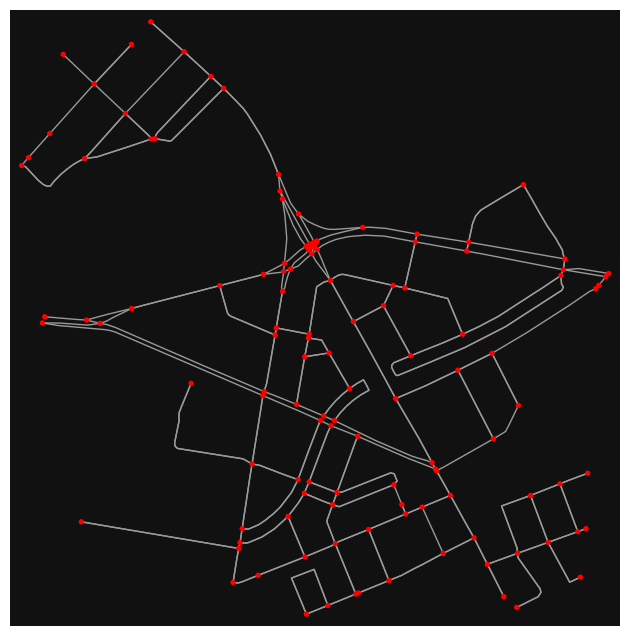

In [11]:
# get a street network and plot it with all edge intersections
point = 55.667708, 12.596266
G = ox.graph_from_point(point, network_type="drive", dist=500)
ox.plot_graph(G, node_color="r");

In [12]:
# get a GeoSeries of consolidated intersections
G_proj = ox.project_graph(G)
intersections = ox.consolidate_intersections(
    G_proj, rebuild_graph=False, tolerance=15, dead_ends=False
)
len(intersections)

73

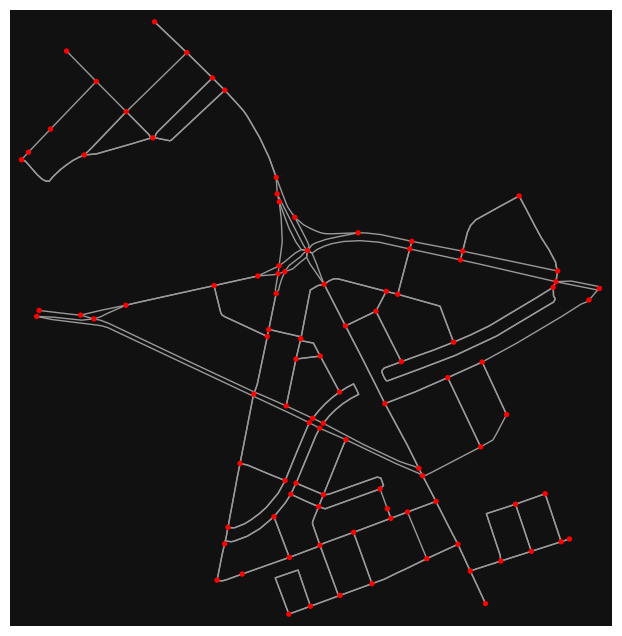

In [16]:
# consolidate intersections and rebuild graph topology
# this reconnects edge geometries to the new consolidated nodes
G2 = ox.consolidate_intersections(G_proj, rebuild_graph=True, tolerance=5, dead_ends=False)
len(G2)
fig, ax = ox.plot_graph(G2, node_color="r")